# Week 5_1: Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

In [1]:
import sframe

In [2]:
loans = sframe.SFrame('lending-club-data.gl/')

[INFO] SFrame v1.8.3 started. Logging /tmp/sframe_server_1458123866.log


In [5]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

In [6]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
             'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [13]:
loans, loans_with_na = loans[[target] + features].dropna_split()

In [14]:
len(loans)

122578

In [15]:
len(loans_with_na)

29

# Make sure the classes are balanced

In [16]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


# One-hot encoding

In [39]:
loans_data = risky_loans.append(safe_loans)

categorical_variables = []
for feat_name, feat_type in zip(loans_data.column_names(), loans_data.column_types()):
    if feat_type == str:
        categorical_variables.append(feat_name)

for feature in categorical_variables:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)

    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

#loans_data.column_names()

# Split data

In [67]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Gradient boosted tree classifier

In [41]:
import sklearn
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

In [116]:
train_label_numpy = np.array(train_data['safe_loans'])
train_data_numpy = train_data.copy()
train_data_numpy = train_data_numpy.remove_column('safe_loans').to_numpy()
train_data_numpy.shape

(37219, 44)

In [51]:
model_5 = GradientBoostingClassifier(max_depth=6, 
                                       n_estimators=5)

In [52]:
model_5.fit(train_data_numpy, train_label_numpy)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

# Making predictions

In [53]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
#sample_validation_data

In [54]:
sample_label_numpy = sample_validation_data['safe_loans']
sample_validation_data_numpy = sample_validation_data.copy()
sample_validation_data_numpy = sample_validation_data.remove_column('safe_loans').to_numpy()

In [55]:
model_5.predict(sample_validation_data_numpy)

array([ 1,  1, -1,  1])

In [56]:
sample_label_numpy

dtype: int
Rows: 4
[1, 1, -1, -1]

In [57]:
print 'model_5 correct:', 3/4.

model_5 correct: 0.75


In [58]:
model_5.predict_proba(sample_validation_data_numpy)

array([[ 0.41642331,  0.58357669],
       [ 0.46949689,  0.53050311],
       [ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

In [59]:
model_5.classes_

array([-1,  1])

In [130]:
print 'The 3rd loan!'

The 3rd loan!


# Evaluating the model on the validation data

In [68]:
validation_label_numpy = np.array(validation_data['safe_loans'])
validation_data_numpy = validation_data.copy()
validation_data_numpy = validation_data_numpy.remove_column('safe_loans').to_numpy()

In [69]:
model_5.score(validation_data_numpy, validation_label_numpy)

0.66146057733735464

In [70]:
predicted_labels = model_5.predict(validation_data_numpy)

In [71]:
len(predicted_labels)

9284

In [72]:
len(validation_label_numpy)

9284

In [78]:
false_labels = predicted_labels[validation_label_numpy != predicted_labels]

In [84]:
print '# of false positives:', (false_labels == +1).sum()

# of false positives: 1652


In [86]:
print '# of false negatives:', len(false_labels) - (false_labels == +1).sum()

# of false negatives: 1491


In [87]:
print 'Cost with model_5:', 1652*20000 + 1491*10000

Cost with model_5: 47950000


# Most positive & negative loans

In [88]:
probability = model_5.predict_proba(validation_data_numpy)

In [91]:
validation_data['predictions'] = probability[:, 1]

In [101]:
validation_data = validation_data.sort('predictions', ascending=False)

In [105]:
# validation_data[:5]
print 'Grade A'

Grade A


In [107]:
#validation_data[-5:]

# Effects of adding more trees

In [121]:
model_10 = GradientBoostingClassifier(max_depth=6, n_estimators=10)
model_50 = GradientBoostingClassifier(max_depth=6, n_estimators=50)
model_100 = GradientBoostingClassifier(max_depth=6, n_estimators=100)
model_200 = GradientBoostingClassifier(max_depth=6, n_estimators=200)
model_500 = GradientBoostingClassifier(max_depth=6, n_estimators=500)

In [122]:
model_10.fit(train_data_numpy, train_label_numpy)
model_50.fit(train_data_numpy, train_label_numpy)
model_100.fit(train_data_numpy, train_label_numpy)
model_200.fit(train_data_numpy, train_label_numpy)
model_500.fit(train_data_numpy, train_label_numpy)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

# Compare accuracy

In [123]:
print 'model_10:', model_10.score(validation_data_numpy, validation_label_numpy)
print 'model_50:', model_50.score(validation_data_numpy, validation_label_numpy)
print 'model_100:', model_100.score(validation_data_numpy, validation_label_numpy)
print 'model_200:', model_200.score(validation_data_numpy, validation_label_numpy)
print 'model_500:', model_500.score(validation_data_numpy, validation_label_numpy)

model_10: 0.666307626023
model_50: 0.68472641103
model_100: 0.688496337785
model_200: 0.690219732874
model_500: 0.689681171909


In [124]:
print 'model_200 is the best!'

model_200 is the best!


# errors vs # of trees

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [126]:
train_err_10 = 1 - model_10.score(train_data_numpy, train_label_numpy)
train_err_50 = 1 - model_50.score(train_data_numpy, train_label_numpy)
train_err_100 = 1 - model_100.score(train_data_numpy, train_label_numpy)
train_err_200 = 1 - model_200.score(train_data_numpy, train_label_numpy)
train_err_500 = 1 - model_500.score(train_data_numpy, train_label_numpy)


train_errors = [train_err_10, 
                train_err_50, 
                train_err_100,
                train_err_200,
               train_err_500]

In [127]:
validation_err_10 = 1 - model_10.score(validation_data_numpy, validation_label_numpy)
validation_err_50 = 1 - model_50.score(validation_data_numpy, validation_label_numpy)
validation_err_100 = 1 - model_100.score(validation_data_numpy, validation_label_numpy)
validation_err_200 = 1 - model_200.score(validation_data_numpy, validation_label_numpy)
validation_err_500 = 1 - model_500.score(validation_data_numpy, validation_label_numpy)


validation_errors = [validation_err_10, 
                validation_err_50, 
                validation_err_100,
                validation_err_200,
                    validation_err_500]

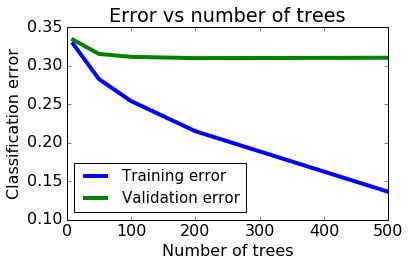

In [129]:
plt.plot([10, 50, 100, 200, 500], train_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')